## Temp

> Just trying stuff

In [ ]:
import asyncio
import json
import pandas as pd
from abc import ABC, abstractmethod
from pathlib import Path
from pydantic import BaseModel
from typing import Union
import aiohttp
import aiofiles
import hashlib

TickerResult = Union[pd.DataFrame, BaseModel]

class TickerModelBase(ABC):
    cache_dir = Path("cache")  # customize if needed

    def __init__(self, ticker: str, retry: int = 1, delay: float = 2.0):
        self.ticker = ticker.upper()
        self.retry = retry
        self.delay = delay

    @abstractmethod
    async def fetch_raw(self) -> Union[dict, str]:
        ...

    @abstractmethod
    def parse(self, raw: Union[dict, str]) -> TickerResult:
        ...

    def cache_path(self) -> Path:
        key = f"{self.__class__.__name__}_{self.ticker}".lower()
        digest = hashlib.md5(key.encode()).hexdigest()
        return self.cache_dir / f"{digest}.json"

    async def read_cache(self) -> Union[dict, str, None]:
        path = self.cache_path()
        if path.exists():
            async with aiofiles.open(path, "r", encoding="utf-8") as f:
                return json.loads(await f.read())
        return None

    async def write_cache(self, data: Union[dict, str]):
        path = self.cache_path()
        path.parent.mkdir(parents=True, exist_ok=True)
        async with aiofiles.open(path, "w", encoding="utf-8") as f:
            await f.write(json.dumps(data))

    async def fetch(self, use_cache: bool = True) -> TickerResult:
        if use_cache:
            cached = await self.read_cache()
            if cached:
                return self.parse(cached)

        for attempt in range(1 + self.retry):
            try:
                raw = await self.fetch_raw()
                await self.write_cache(raw)
                return self.parse(raw)
            except Exception as e:
                if attempt < self.retry:
                    await asyncio.sleep(self.delay)
                else:
                    raise e

In [ ]:
import yfinance as yf

class YahooHistoryModel(TickerModelBase):
    async def fetch_raw(self) -> dict:
        loop = asyncio.get_running_loop()
        df = await loop.run_in_executor(None, lambda: yf.Ticker(self.ticker).history(period="1y"))
        return df.reset_index().to_dict(orient="records")

    def parse(self, raw: list[dict]) -> pd.DataFrame:
        return pd.DataFrame(raw)

In [ ]:
from bs4 import BeautifulSoup

class SomeScraperModel(TickerModelBase):
    async def fetch_raw(self) -> str:
        url = f"https://example.com/{self.ticker}"
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as resp:
                return await resp.text()

    def parse(self, raw: str) -> BaseModel:
        soup = BeautifulSoup(raw, "html.parser")
        value = soup.select_one("span#eps").text
        return SomeModel(eps=float(value))

In [ ]:
import asyncio

async def main():
    model = YahooHistoryModel("AAPL")
    result = await model.fetch()
    print(result.head() if isinstance(result, pd.DataFrame) else result)

asyncio.run(main())

In [ ]:
import asyncio
from abc import ABC, abstractmethod
from typing import Union, Optional, Dict, Any, Type
from pathlib import Path
from datetime import datetime, date
import pandas as pd
from pydantic import BaseModel
import json
import requests
from time import sleep
import logging

# Base configuration model
class ProviderConfig(BaseModel):
    """Base configuration for data providers"""
    name: str
    base_url: str
    timeout: int = 30
    retry_delay: int = 3
    cache_ttl_hours: int = 24

# Abstract base class for all data providers
class BaseDataProvider(ABC):
    """Abstract base class for financial data providers"""
    
    def __init__(self, config: ProviderConfig, cache_base_path: Path):
        self.config = config
        self.cache_base_path = cache_base_path
        self.logger = logging.getLogger(f"{self.__class__.__name__}")
        
    def get_data(self, ticker: str, force_refresh: bool = False) -> Union[pd.DataFrame, BaseModel]:
        """
        Main entry point to get data for a ticker
        
        Args:
            ticker: Stock ticker symbol
            force_refresh: Skip cache and fetch fresh data
            
        Returns:
            Either a DataFrame or Pydantic model based on provider implementation
        """
        if not force_refresh:
            cached_data = self._load_from_cache(ticker)
            if cached_data is not None:
                self.logger.info(f"Cache hit for {ticker}")
                return cached_data
        
        self.logger.info(f"Fetching fresh data for {ticker}")
        data = self._fetch_and_process(ticker)
        self._save_to_cache(ticker, data)
        return data
    
    def _fetch_and_process(self, ticker: str) -> Union[pd.DataFrame, BaseModel]:
        """Fetch raw data and process it"""
        raw_data = self._fetch_raw_data(ticker)
        return self._process_raw_data(ticker, raw_data)
    
    def _fetch_raw_data(self, ticker: str) -> str:
        """Fetch raw data with retry logic"""
        url = self._build_url(ticker)
        
        for attempt in range(2):  # Initial attempt + 1 retry
            try:
                response = requests.get(url, timeout=self.config.timeout, **self._get_request_params())
                response.raise_for_status()
                return response.text
            except requests.RequestException as e:
                if attempt == 0:
                    self.logger.warning(f"Request failed for {ticker}, retrying in {self.config.retry_delay}s: {e}")
                    sleep(self.config.retry_delay)
                else:
                    self.logger.error(f"Request failed for {ticker} after retry: {e}")
                    raise
    
    def _get_cache_path(self, ticker: str) -> Path:
        """Get cache file path for a ticker"""
        today = datetime.now().strftime("%Y%m%d")
        cache_dir = self.cache_base_path / self.config.name / today
        cache_dir.mkdir(parents=True, exist_ok=True)
        
        extension = "parquet" if self._returns_dataframe() else "json"
        return cache_dir / f"{ticker.upper()}.{extension}"
    
    def _load_from_cache(self, ticker: str) -> Optional[Union[pd.DataFrame, BaseModel]]:
        """Load data from cache if available and valid"""
        cache_path = self._get_cache_path(ticker)
        
        if not cache_path.exists():
            return None
            
        try:
            if self._returns_dataframe():
                return pd.read_parquet(cache_path)
            else:
                with open(cache_path, 'r') as f:
                    data = json.load(f)
                return self._get_pydantic_model()(**data)
        except Exception as e:
            self.logger.warning(f"Failed to load cache for {ticker}: {e}")
            return None
    
    def _save_to_cache(self, ticker: str, data: Union[pd.DataFrame, BaseModel]) -> None:
        """Save data to cache"""
        cache_path = self._get_cache_path(ticker)
        
        try:
            if isinstance(data, pd.DataFrame):
                data.to_parquet(cache_path)
            else:
                with open(cache_path, 'w') as f:
                    json.dump(data.model_dump(), f, indent=2, default=str)
            self.logger.info(f"Cached data for {ticker} at {cache_path}")
        except Exception as e:
            self.logger.error(f"Failed to cache data for {ticker}: {e}")
    
    # Abstract methods to be implemented by subclasses
    @abstractmethod
    def _build_url(self, ticker: str) -> str:
        """Build the API URL for the ticker"""
        pass
    
    @abstractmethod
    def _process_raw_data(self, ticker: str, raw_data: str) -> Union[pd.DataFrame, BaseModel]:
        """Process raw API response into final format"""
        pass
    
    @abstractmethod
    def _returns_dataframe(self) -> bool:
        """Return True if this provider returns DataFrames, False for Pydantic models"""
        pass
    
    def _get_request_params(self) -> Dict[str, Any]:
        """Override to add headers, auth, etc."""
        return {}
    
    def _get_pydantic_model(self) -> Type[BaseModel]:
        """Override to return the Pydantic model class for non-DataFrame providers"""
        raise NotImplementedError("Must implement _get_pydantic_model for non-DataFrame providers")


# Example implementations
class YahooFinanceConfig(ProviderConfig):
    """Yahoo Finance specific configuration"""
    name: str = "yahoo_finance"
    base_url: str = "https://query1.finance.yahoo.com/v8/finance/chart/"

class YahooFinanceHistoryProvider(BaseDataProvider):
    """Yahoo Finance historical data provider (returns DataFrame)"""
    
    def _build_url(self, ticker: str) -> str:
        return f"{self.config.base_url}{ticker}"
    
    def _returns_dataframe(self) -> bool:
        return True
    
    def _process_raw_data(self, ticker: str, raw_data: str) -> pd.DataFrame:
        """Process Yahoo Finance JSON response into DataFrame"""
        import json
        data = json.loads(raw_data)
        
        # Extract the chart data (simplified example)
        result = data['chart']['result'][0]
        timestamps = result['timestamp']
        quotes = result['indicators']['quote'][0]
        
        df = pd.DataFrame({
            'timestamp': pd.to_datetime(timestamps, unit='s'),
            'open': quotes['open'],
            'high': quotes['high'],
            'low': quotes['low'],
            'close': quotes['close'],
            'volume': quotes['volume']
        })
        
        return df.set_index('timestamp')


# Pydantic models for structured data
class CompanyProfile(BaseModel):
    """Example Pydantic model for company profile data"""
    ticker: str
    company_name: str
    sector: str
    industry: str
    market_cap: Optional[float] = None
    pe_ratio: Optional[float] = None
    forward_pe: Optional[float] = None

class ZacksConfig(ProviderConfig):
    """Zacks specific configuration"""
    name: str = "zacks"
    base_url: str = "https://api.zacks.com/v1/"
    api_key: str

class ZacksProfileProvider(BaseDataProvider):
    """Zacks company profile provider (returns Pydantic model)"""
    
    def _build_url(self, ticker: str) -> str:
        return f"{self.config.base_url}company/profile/{ticker}"
    
    def _returns_dataframe(self) -> bool:
        return False
    
    def _get_pydantic_model(self) -> Type[BaseModel]:
        return CompanyProfile
    
    def _get_request_params(self) -> Dict[str, Any]:
        return {"headers": {"X-API-Key": self.config.api_key}}
    
    def _process_raw_data(self, ticker: str, raw_data: str) -> CompanyProfile:
        """Process Zacks JSON response into Pydantic model"""
        import json
        from jmespath import search
        
        data = json.loads(raw_data)
        
        # Use jmespath to extract data
        return CompanyProfile(
            ticker=ticker,
            company_name=search('company.name', data) or "",
            sector=search('company.sector', data) or "",
            industry=search('company.industry', data) or "",
            market_cap=search('metrics.market_cap', data),
            pe_ratio=search('metrics.pe_ratio', data),
            forward_pe=search('metrics.forward_pe', data)
        )


# Example XML provider for IBKR
class IBKRConfig(ProviderConfig):
    """IBKR specific configuration"""
    name: str = "ibkr"
    base_url: str = "https://api.ibkr.com/v1/"
    username: str
    password: str

class IBKRDataProvider(BaseDataProvider):
    """IBKR XML data provider example"""
    
    def _build_url(self, ticker: str) -> str:
        return f"{self.config.base_url}market-data/{ticker}"
    
    def _returns_dataframe(self) -> bool:
        return False
    
    def _get_pydantic_model(self) -> Type[BaseModel]:
        return CompanyProfile  # Simplified example
    
    def _process_raw_data(self, ticker: str, raw_data: str) -> CompanyProfile:
        """Process IBKR XML response"""
        import xml.etree.ElementTree as ET
        
        root = ET.fromstring(raw_data)
        
        # Use xpath-like operations to extract data
        return CompanyProfile(
            ticker=ticker,
            company_name=root.find('.//company/name').text if root.find('.//company/name') is not None else "",
            sector=root.find('.//company/sector').text if root.find('.//company/sector') is not None else "",
            industry=root.find('.//company/industry').text if root.find('.//company/industry') is not None else ""
        )


# Usage example
if __name__ == "__main__":
    # Setup logging
    logging.basicConfig(level=logging.INFO)
    
    # Cache directory
    cache_path = Path("./cache")
    
    # Yahoo Finance example
    yahoo_config = YahooFinanceConfig()
    yahoo_provider = YahooFinanceHistoryProvider(yahoo_config, cache_path)
    
    try:
        df = yahoo_provider.get_data("AAPL")
        print(f"Yahoo data shape: {df.shape}")
    except Exception as e:
        print(f"Yahoo error: {e}")
    
    # Zacks example
    zacks_config = ZacksConfig(api_key="your-api-key")
    zacks_provider = ZacksProfileProvider(zacks_config, cache_path)
    
    try:
        profile = zacks_provider.get_data("AAPL")
        print(f"Zacks profile: {profile}")
    except Exception as e:
        print(f"Zacks error: {e}")

[*********************100%***********************]  4 of 4 completed


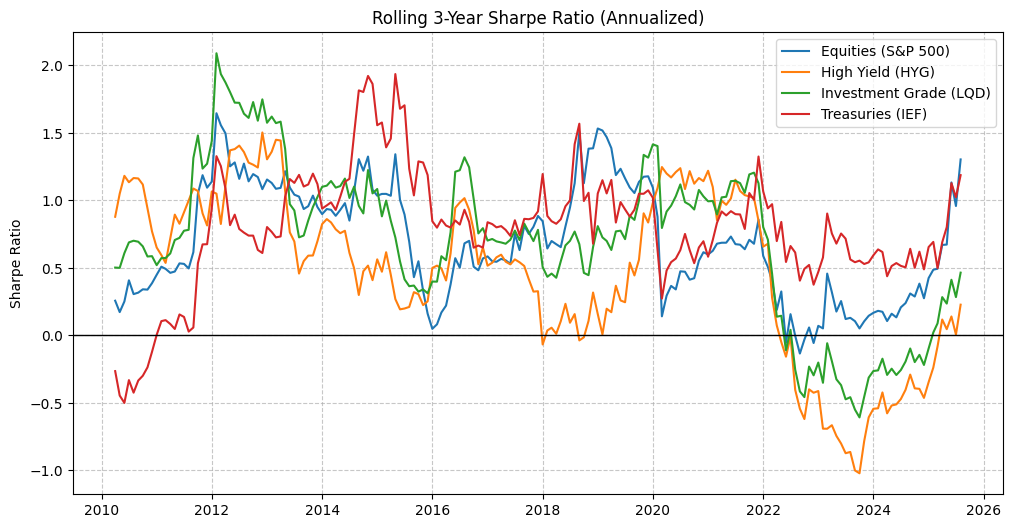

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tickers for proxies
tickers = {
    "Equities (S&P 500)": "^GSPC",
    "High Yield (HYG)": "HYG",
    "Investment Grade (LQD)": "LQD",
    "Treasuries (IEF)": "IEF"
}

# Download monthly adjusted close prices
data = yf.download(list(tickers.values()), start="2005-01-01", interval="1mo", auto_adjust=False)["Adj Close"]

# Rename columns to friendly names
data.columns = tickers.keys()

# Compute monthly returns
returns = data.pct_change().dropna()

# Define risk-free rate (can use 3M T-bill, but assume ~0 for simplicity)
rf = 0.0

# Function to compute rolling Sharpe ratio
def rolling_sharpe(returns, window=36):
    excess = returns - rf/12
    mean = excess.rolling(window).mean()
    vol = excess.rolling(window).std()
    sharpe = (mean / vol) * np.sqrt(12)  # annualize
    return sharpe

# Compute rolling 3Y Sharpe ratio for each asset
rolling_sharpes = pd.DataFrame({col: rolling_sharpe(returns[col]) for col in returns.columns})

# Plot
plt.figure(figsize=(12,6))
for col in rolling_sharpes.columns:
    plt.plot(rolling_sharpes.index, rolling_sharpes[col], label=col)

plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling 3-Year Sharpe Ratio (Annualized)")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
